# Mean Variance Frontier with Short Sales Constraints

## Load Packages and Utility Functions

In [1]:
using Printf, LinearAlgebra, Optim

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))       #use pyplot or gr
gr(size=(480,320))
default(fmt = :svg)

# Traditional MV Calculations 

(no constraints)

In [3]:
μ = [11.5, 9.5, 6]/100      #expected returns
Σ = [166  34  58;           #covariance matrix
      34  64   4;
      58   4 100]/100^2

assetNames = ["A","B","C"];
n = length(μ)

3

## A Function for Calculating the (traditional) Mean-Variance Frontier


In [4]:
"""
    MVCalc(μstar,μ,Σ)

Calculate the std and weights of a portfolio (with mean return μstar) on MVF of risky assets.

# Remark
- Only (λ,δ) and thus (w,stdRp) depend on μstar. We could therefore speed up the computations a bit
by doing the loop over different μstar values inside the function (and thus not recalculate Σ_1,a,b,c).
"""
function MVCalc(μstar,μ,Σ)
    n    = length(μ)
    Σ_1  = inv(Σ)
    a    = μ'Σ_1*μ
    b    = μ'Σ_1*ones(n)
    c    = ones(n)'Σ_1*ones(n)
    λ    = (c*μstar - b)/(a*c-b^2)
    δ    = (a-b*μstar)/(a*c-b^2)
    w    = Σ_1 *(μ*λ.+δ)
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

MVCalc

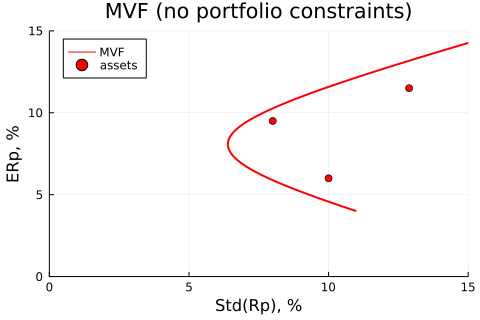

In [5]:
μstar_range = range(0.04,0.15,length=201)
L           = length(μstar_range)

StdRp  = fill(NaN,L)
for i = 1:L
    StdRp[i] = MVCalc(μstar_range[i],μ,Σ)[1]
end

p1 = plot( StdRp*100,μstar_range*100,
           linecolor = :red,
           linewidth = 2,
           label = "MVF",
           legend = :topleft,
           xlim = (0,15),
           ylim = (0,15),
           title = "MVF (no portfolio constraints)",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red,label="assets")
display(p1)

# The Maximization Problem

The investor maximizes:

$\text{E}R_{p}-\frac{k}{2} \text{Var}(R_{p})$,

where $\text{E}R_{p}= w'\mu$ and $\text{Var}(R_{p}=w'\Sigma w$

subject to $\Sigma_{i=1}^n w_{i} = 1$.

We can trace out the mean-variance frontier by solving this problem for different values of $k$.

To impose the restriction, optimise over `v` and let `w=[v;1-sum(v)]`

In [6]:
function objfun1(v,k,μ,Σ)
    w      = [v;1-sum(v)]
    ERp    = w'μ
    VarRp  = w'Σ*w
    StdRp  = sqrt(VarRp)
    U      = ERp - k/2*VarRp
    loss   = -U                    #minimise this
    return loss, w, ERp, StdRp
end

objfun1 (generic function with 1 method)

In [7]:
k = 10
Sol = optimize(v -> objfun1(v,k,μ,Σ)[1],zeros(n-1))

v   = Optim.minimizer(Sol)
(_,w,ERp,StdRp) = objfun1(v,k,μ,Σ)

printmat(w,rowNames=assetNames)
printmat([StdRp,ERp],rowNames=["σₚ","μₚ"])

A     0.313
B     0.695
C    -0.008

σₚ     0.079
μₚ     0.102



# Task 1

Redo the optimisation for the following range of $k$ values:
`k = [range(0.1,1.9,length=30);range(1,30,length=25)]`

Then plot the resulting "efficient frontier" (similar to the MV plot above). Is is the same as the plot above?

# Task 2

Change the optimisation problem to `U = ERp + cost - k/2*VarRp` where `cost` is (sum of the *negative* portfolio weights)*0.05. This is a (crude/dramatic) attaempt to illustrate the impact of costs of short selling ($w_i<0$) assets. Plot the new "effecient frontier" together with the old one.

# Task 3

Compare the portfolio weights (with/without the extra `cost`)